In [1]:
import numpy as np
import pandas as pd
import datetime 
import time

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

from pandas.core.common import flatten

import pyspark.sql.functions as f
from pyspark.sql.types import IntegerType
from pyspark.sql import Window

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)

In [2]:
events = pd.read_csv('data/events.csv')
category_tree = pd.read_csv('data/category_tree.csv')
item_properties_1 = pd.read_csv('data/item_properties_part1.csv')
item_properties_2 = pd.read_csv('data/item_properties_part2.csv')
items = pd.concat([item_properties_1, item_properties_2])

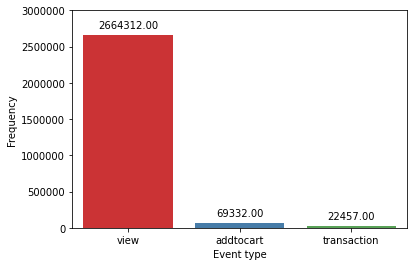

In [6]:
# Display event types
group_df = pd.DataFrame(events['event'].value_counts())
splot = sns.barplot(x=group_df.index, y=group_df['event'], data= group_df, palette="Set1")
plt.ticklabel_format(style='plain', axis='y')
plt.xlabel("Event type")
plt.ylabel("Frequency")
plt.ylim(0,3e6)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.show()

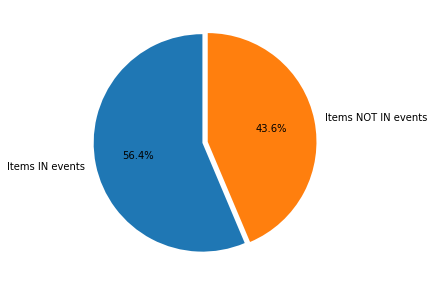

In [7]:
# Display unique items in events and not in events
labels = ['Items IN events', "Items NOT IN events"]
sizes = np.array([len(np.unique(events['itemid'])), len(np.unique(items['itemid']))- len(np.unique(events['itemid']))])
explode = (0, 0.05) 
plt.subplots(figsize=(5,5))
plt.pie(sizes, explode=explode, labels=labels,autopct='%1.1f%%', shadow=False, startangle=90)
# plt.axis('equal')
plt.show()

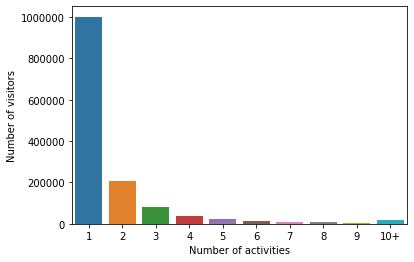

In [8]:
# Analysis 1:
# Display visitor activity
count_uid = events.groupby('visitorid')[['event']].count()
count_users = []
for i in range(1,11):
    if i<10:
        count_users.append(count_uid.loc[count_uid.event==i].shape[0])
    else:
        count_users.append(count_uid.loc[count_uid.event>i].shape[0])
df = pd.DataFrame({"nb_views":[i+1 for i in range(0,10)], "nb_visitors":count_users})
df["nb_views"][9] = "10+"
splot = sns.barplot(x=df['nb_views'], y=df['nb_visitors'], data=df)
plt.xlabel("Number of activities")
plt.ylabel("Number of visitors")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

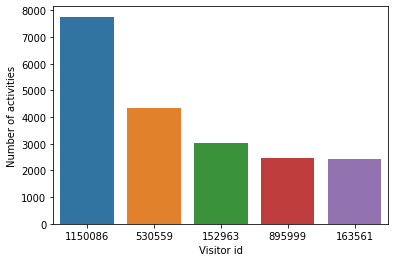

In [9]:
# Explore top 5 most visitors
count_uid = events.groupby('visitorid')[['event']].count().sort_values(by='event', ascending=False)
df = pd.DataFrame({"visitorid":count_uid[:5].index, "num_activity":count_uid[:5].values[:,0]})
sns.barplot(x='visitorid', y='num_activity', data=df, order=df.sort_values('num_activity', ascending = False).visitorid)
plt.xlabel("Visitor id")
plt.ylabel("Number of activities")
plt.show()

In [12]:
# Analysis 2:
# Explore the most viewed, added to cart and selling items
grouped = events.groupby('event')['itemid'].apply(list)
print(grouped)
def analyze_event(event_name, k, palette_name):
    grouped = events.groupby('event')['itemid'].apply(list)
    selection = grouped[event_name]
    count_selection ={}
    selection = np.array(selection[:])
    unique, counts = np.unique(selection, return_counts=True)
    count_selection = dict(zip(unique, counts))
    sort_count_selection = sorted(count_selection.items(), key = lambda elem: elem[1], reverse = True)
    x = top_selection = [i[0] for i in sort_count_selection[:k]]
    y = top_count = [i[1] for i in sort_count_selection[:k]]

    # Plot
    plt.figure(figsize=(10,5))
    custom_palette = sns.color_palette(palette_name, k)
    sns.barplot(x, y, order=x, palette=custom_palette)
    plt.xlabel("Item id")
    plt.ylabel("Count")
    plt.title (f"Top {k} {event_name.upper()} items")
    plt.show()
    return top_selection, top_count

event
addtocart      [5206, 10572, 255275, 356475, 312728, 63312, 1...
transaction    [356475, 15335, 81345, 150318, 310791, 54058, ...
view           [355908, 248676, 318965, 253185, 367447, 22556...
Name: itemid, dtype: object


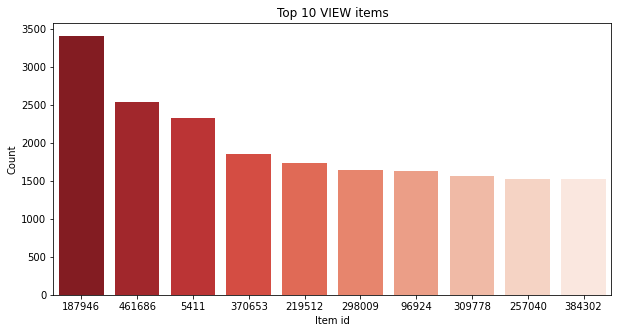

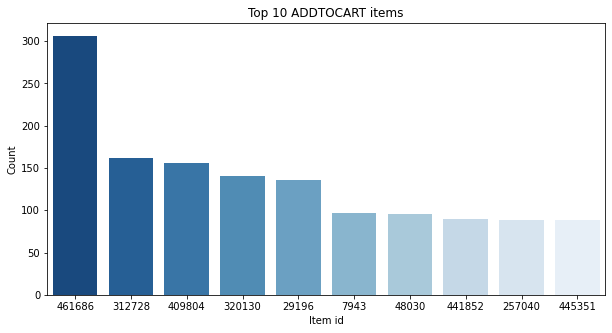

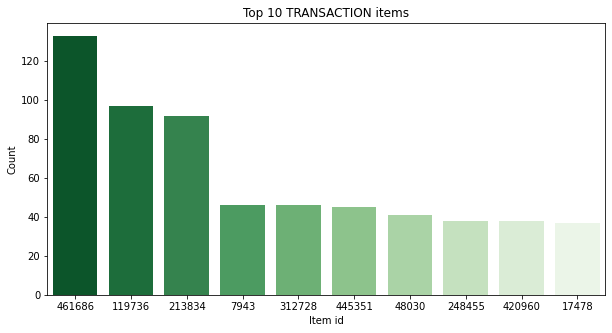

In [13]:
top_view, _ = analyze_event('view', 10, "Reds_r")
top_addtocart, _ = analyze_event('addtocart', 10, "Blues_r")
top_transaction, transaction_count = analyze_event('transaction', 10, "Greens_r")

In [17]:
# Personalized Recommendation - Basic association rule recommendation 
customer_transaction = events[events.transactionid.notnull()].visitorid.unique()
transaction_items = []
for u in customer_transaction:
    transaction_items.append(list(events.loc[(events.visitorid == u) & (events.transactionid.notnull())].itemid.values))    

def association_recommendation(item_id, transaction_items):
    recommendation = []
    for x in transaction_items:
        if item_id in x:
            recommendation.append(x)
    recommendation = flatten(recommendation)
    recommendation = list(set(recommendation) - set([item_id]))
    return recommendation

In [18]:
association_recommendation(25353, transaction_items)

[105792, 200793, 12836, 80582, 380775, 15335, 400969, 302422, 237753, 317178]

In [4]:
events=spark.read.csv('data/events.csv',  header= True, inferSchema = True)
events = events.withColumn('datetime', f.from_unixtime((events.timestamp.cast('bigint')/1000)).cast('timestamp'))
events = events.withColumn('day_of_week',f.dayofweek(events['datetime']))
events = events.withColumn('day_of_month',f.dayofmonth(events['datetime']))
events = events.withColumn('hour_of_day',f.hour(events['datetime']))

<AxesSubplot:xlabel='day of week'>

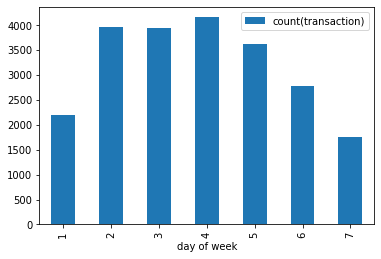

In [5]:
df_buy_day = events.where(f.col("event") =="transaction").groupby('day_of_week').agg(f.count("event"))
df_buy_day = df_buy_day.toDF('day of week','count(transaction)')
df_buy_day = df_buy_day.toPandas()
df_buy_day = df_buy_day.sort_values(by='day of week')
df_buy_day.plot.bar(x='day of week', y='count(transaction)')

<AxesSubplot:xlabel='day of month'>

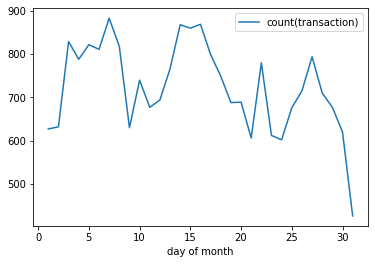

In [6]:
df_buy_month = events.where(f.col("event") =="transaction").groupby('day_of_month').agg(f.count("event"))
df_buy_month = df_buy_month.toDF('day of month','count(transaction)')
df_buy_month = df_buy_month.toPandas()
df_buy_month = df_buy_month.sort_values(by='day of month')
df_buy_month.plot.line(x='day of month', y='count(transaction)')

<AxesSubplot:xlabel='hour of day'>

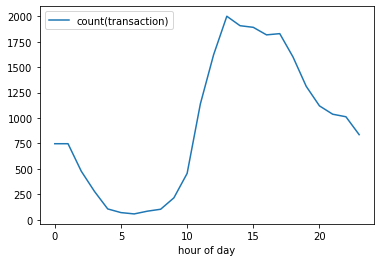

In [7]:
df_buy_hour = events.where(f.col("event") =="transaction").groupby('hour_of_day').agg(f.count("event"))
df_buy_hour = df_buy_hour.toDF('hour of day','count(transaction)')
df_buy_hour = df_buy_hour.toPandas()
df_buy_hour = df_buy_hour.sort_values(by='hour of day')
df_buy_hour.plot.line(x='hour of day', y='count(transaction)')

In [8]:
def convert_to(event):
    if event == "transaction":
        return 1
    return 0

In [9]:
udf_convert_event = f.udf(convert_to, IntegerType())
events = events.withColumn("event", udf_convert_event(f.col("event")))

In [10]:
#keep one interaction for each pair visitor-item
w = Window.partitionBy(events["visitorid"], events["itemid"])
events = events.withColumn('maxEvent', f.max(f.col("event")).
                             over(w)).where(f.col("event")==f.col("maxEvent")).drop(f.col("maxEvent"))

In [12]:
def convert_to1(event):
    if event > 0:
        return 1
    return 0

<AxesSubplot:xlabel='day of week'>

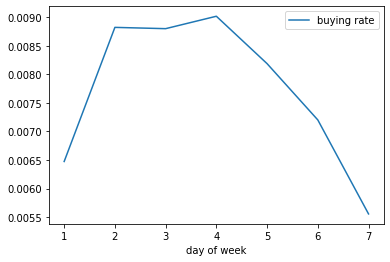

In [13]:
df_dw = events.groupby("visitorid",'day_of_week').\
agg(f.mean("event"))
udf_convert_event1 = f.udf(convert_to1, IntegerType())
df_dw = df_dw.withColumn("avg(event)", udf_convert_event1(f.col("avg(event)")))
df_dw = df_dw.groupby('day_of_week').agg(f.mean("avg(event)"))
df_dw = df_dw.toDF('day of week','buying rate')
df_dw_pd = df_dw.toPandas()
df_dw_pd = df_dw_pd.sort_values(by='day of week')
df_dw_pd.plot.line(x='day of week', y='buying rate')

<AxesSubplot:xlabel='day of month'>

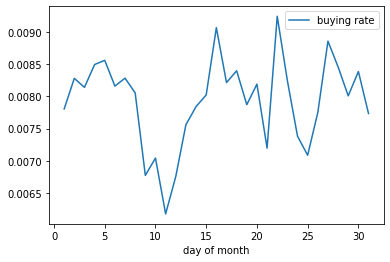

In [14]:
df_dm = events.groupby("visitorid",'day_of_month').\
agg(f.mean("event"))
df_dm = df_dm.withColumn("avg(event)", udf_convert_event1(f.col("avg(event)")))

df_dm = df_dm.groupby('day_of_month').agg(f.mean("avg(event)"))
df_dm = df_dm.toDF('day of month','buying rate')
df_dw = df_dw.toDF('day of month','buying rate')
df_dm_pd = df_dm.toPandas()
df_dm_pd = df_dm_pd.sort_values(by='day of month')
df_dm_pd.plot.line(x='day of month', y='buying rate')

<AxesSubplot:xlabel='hour of day'>

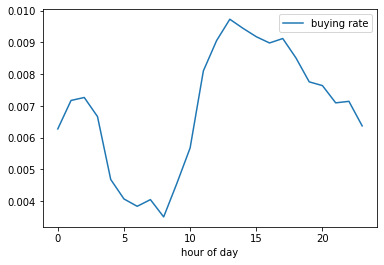

In [15]:
df_hd = events.groupby("visitorid",'hour_of_day').\
agg(f.mean("event"))
df_hd = df_hd.withColumn("avg(event)", udf_convert_event1(f.col("avg(event)")))

df_hd = df_hd.groupby('hour_of_day').agg(f.mean("avg(event)"))
df_hd = df_hd.toDF('hour of day','buying rate')
df_hd = df_hd.toDF('hour of day','buying rate')
df_hd_pd = df_hd.toPandas()
df_hd_pd = df_hd_pd.sort_values(by='hour of day')
df_hd_pd.plot.line(x='hour of day', y='buying rate')